In [50]:
import tensorflow as tf
import zipfile
import os
import glob
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Uncomment this if you're running on google colab
from google.colab import drive
drive.mount('/content/drive')

In [2]:
def unzip_file(zip_path, extract_to):
    """
    Unzip a zip file and maintain its directory structure.

    Args:
    zip_path (str): The path to the zip file.
    extract_to (str): The directory to extract the files into.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extrait tous les fichiers dans le répertoire spécifié
        zip_ref.extractall(extract_to)
        print(f"Files extracted to {extract_to}")

# Utiliser la fonction
zip_file_path_train = 'C:/Users/ou_ba/Desktop/DL_project/Financial_Data.zip'
zip_file_path_test = 'C:/Users/ou_ba\Desktop/DL_project/Financial_Data_test.zip'

destination_path = 'C:/Users/ou_ba/Desktop/DL_project/data/'
unzip_file(zip_file_path_train, destination_path)
unzip_file(zip_file_path_test , destination_path)

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ou_ba\AppData\Local\Temp\ipykernel_38216\2473166043.py:16: SyntaxWarning: invalid escape sequence '\D'
  zip_file_path_test = 'C:/Users/ou_ba\Desktop/DL_project/Financial_Data_test.zip'


Files extracted to C:/Users/ou_ba/Desktop/DL_project/data/
Files extracted to C:/Users/ou_ba/Desktop/DL_project/data/


In [7]:
folder_path_train = 'C:/Users/ou_ba/Desktop/DL_project/data/Financial Data'
folder_path_test = 'C:/Users/ou_ba/Desktop/DL_project/data/Financial_data_test'
total_images_train = len(glob.glob(os.path.join(folder_path_train, '**/*.[jJ][pP][eE][gG]'), recursive=True))
total_images_test = len(glob.glob(os.path.join(folder_path_test, '**/*.[jJ][pP][eE][gG]'), recursive=True))
print(f"Total number of .jpeg images_train: {total_images_train}")
print(f"Total number of .jpeg images_test: {total_images_test}")

Total number of .jpeg images_train: 47996
Total number of .jpeg images_test: 39996


In [51]:
import os
import pandas as pd

def create_full_img_class_df(base_path):
    """
    Create a DataFrame with image paths and their corresponding labels by traversing the directory structure.

    Args:
    base_path (str): The path to the directory containing subdirectories of images.

    Returns:
    DataFrame: A DataFrame with columns 'img' for image paths and 'label' for their corresponding labels.
    """
    data = pd.DataFrame()
    img_rows = []
    label_rows = []

    # List all subdirectories (each representing a label)
    for label in sorted(os.listdir(base_path)):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            # List all image files in the subdirectory
            for img_file in sorted(os.listdir(label_path)):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(label_path, img_file)
                    img_rows.append(img_path)
                    label_rows.append(label)

    data['img'] = img_rows
    data['label'] = label_rows


    return data



# Create the DataFrame
df_train = create_full_img_class_df(folder_path_train)
df_test= create_full_img_class_df(folder_path_test)
X_train,X_val, y_train, y_val = train_test_split(df_train['img'], df_train['label'], test_size = 0.2, stratify = df_train['label'])
# Step 1: Convert labels to integers
label_encoder = LabelEncoder()

# Fit the encoder and transform the training labels
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the validation labels
y_val_encoded = label_encoder.transform(y_val)

# Step 2: Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train_encoded)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val_encoded)).batch(32)

# Display the DataFrame
print(X_train.shape[0])
print(X_val.shape[0])
print(df_test.shape[0])



38396
9600
39996


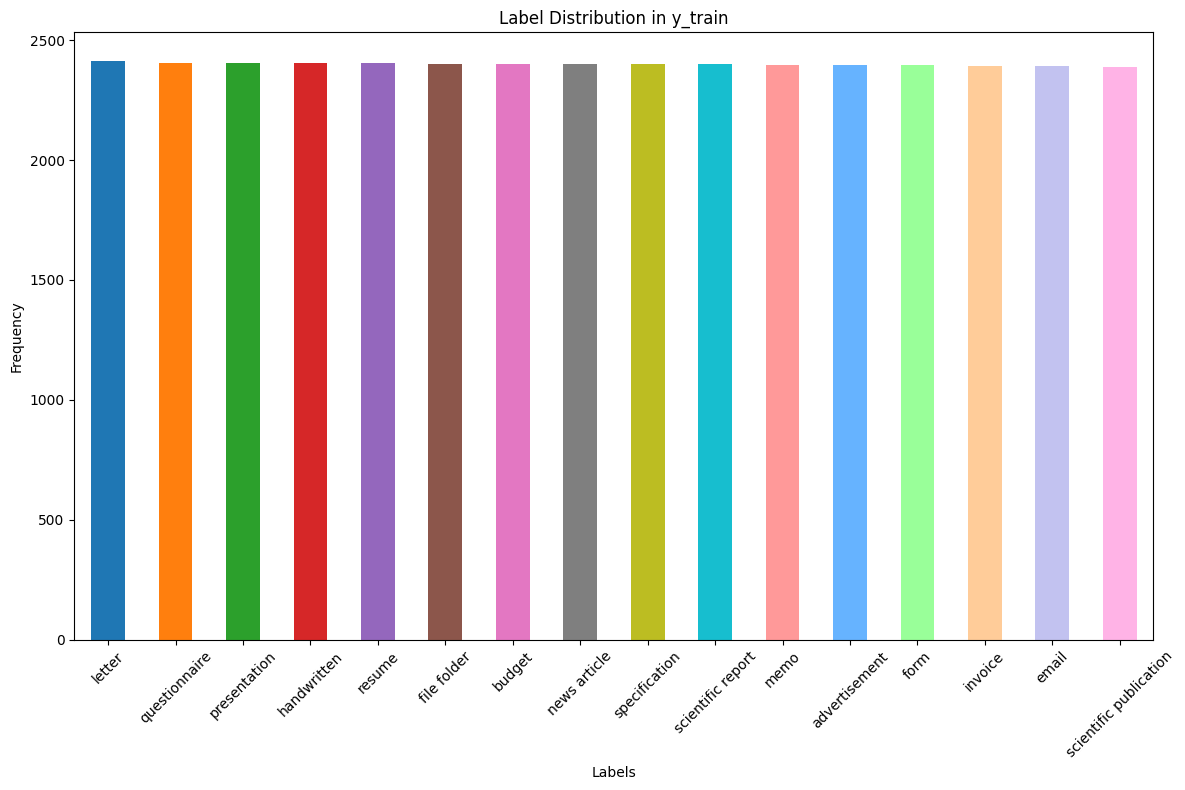

In [52]:

# Count the occurrences of each label in y_train
label_counts = y_train.value_counts()

colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
    'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', '#ff9999', '#66b3ff',
    '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6'
]

# Plot the histogram
plt.figure(figsize=(12, 8))
label_counts.plot(kind='bar', color=colors)
plt.title('Label Distribution in y_train')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='', linewidth=0.7)
plt.tight_layout()
plt.show()
#  La proportion d'images est équilibrée, ce qui garantit qu'aucune classe n'est sur-représentée par rapport aux autres

In [18]:
# Initialize variables to track min and max dimensions
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Iterate over each image path in the DataFrame
for img_path in df_train['img']:
    # Open the image using PIL
    with Image.open(img_path) as img:
        # Get image dimensions
        width, height = img.size

        # Update min and max dimensions
        if width < min_width:
            min_width = width
        if height < min_height:
            min_height = height
        if width > max_width:
            max_width = width
        if height > max_height:
            max_height = height

# Print the results
print(f"Minimum image size: {min_width}x{min_height}")
print(f"Maximum image size: {max_width}x{max_height}")

# La taille des images est différente ; il est nécessaire de standardiser leur taille :)

Minimum image size: 607x1000
Maximum image size: 3235x1000


In [54]:
# Find all unique labels in y_train
unique_labels_train = y_train.unique()

# Create a single mapping dictionary based on the training labels
label2id = {label: i for i, label in enumerate(unique_labels_train)}
# Create the inverse mapping dictionary from id to label
id2label = {i: label for label, i in label2id.items()}


# Convert the labels in y_train and y_val to indices
y_train_mapped = y_train.map(label2id)
y_val_mapped = y_val.map(label2id)

# Print the mapped y_val
print(y_val_mapped)

32719     5
44999    12
40678    14
27120     6
34212     4
         ..
16888    15
15869    15
6847     13
14616     9
16489    15
Name: label, Length: 9600, dtype: int64


In [37]:
# TensorFlow's ImageDataGenerator for data augmentation and preprocessing.
# Define the image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,  # Random horizontal flip
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalization (same mean and std as training if you wish)
)


In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Assuming you already have your DataFrame df_train with 'img' and 'label' columns
X_train, X_val, y_train, y_val = train_test_split(df_train['img'], df_train['label'], test_size=0.2, stratify=df_train['label'])

# Step 1: Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))  # Resize to the target size
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Step 2: Create TensorFlow datasets
def create_dataset(img_paths, labels, batch_size=32):
    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    
    # Map the loading and preprocessing function to the dataset
    def map_fn(x, y):
        img = tf.numpy_function(load_and_preprocess_image, [x], tf.float32)
        img.set_shape([224, 224, 3])  # Set the shape explicitly
        return img, y

    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(img_paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create datasets for training and validation
train_dataset = create_dataset(X_train, y_train_encoded)
val_dataset = create_dataset(X_val, y_val_encoded)

# Step 3: Create the CNN model
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
model = create_cnn_model(input_shape=(224, 224, 3), num_classes=len(label_encoder.classes_))

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Using sparse_categorical_crossentropy for integer labels
    metrics=['accuracy']
)

# Step 4: Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs as needed
)


Epoch 1/10


C:\Users\ou_ba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/1200 ━━━━━━━━━━━━━━━━━━━━ 55:38:21 167s/step - accuracy: 0.0625 - loss: 2.7895

KeyboardInterrupt: 